# Graph-based Decoding

This notebook walks through how to use a Graph-based decoding approach [1] to process spatial transcriptomic data. Graph-based decoding can only be applied to assays with one-hot-encoding codebooks (i.e. a single fluorescent channel active per round). We will first see how the graph-based decoding module works with some toy examples, and after we apply it on a real application with <em>in situ</em> sequencing data.

The graph based decoding module ```LocalGraphBlobDetector``` builds a graph out of the candidate spots detected by an arbitrary spot finder algorithm (please see [documentation](https://spacetx-starfish.readthedocs.io/en/stable/) for a list of spot finder algorithms included in the module). Nodes of the graph representing detected spots are then connected with edges based on spatial distances. Cost weights proportional to the distance and quality of the detected spots are then assigned to each edge connecting a pair of nodes. Genes are finally decoded by optimizing the graph with respect to the edge costs providing the best spots configuration with higher qualities and smaller distances.

<sup>In details, ```LocalGraphBlobDetector``` first finds spots for every channel and round. Four possible spot detectors are integrated from [scikit-image](https://scikit-image.org/), two based local maxima and two blob detection algorithms. Secondly, overlapping spots are merged across channels within each round in order to handle fluorescent bleed-trough. Next, a quality score is assigned for each detected spot (maximum channel intensity divided by channel intensity vector l2-norm). Detected spots belonging to different sequencing rounds and closer than `search_radius` are connected in a graph, forming connected components of spot detections. Next, for each connected component, edges between not connected spots belonging to consecutive rounds are forced if they are closer than `search_radius_max`. Finally, all the edges that connect spots not belonging to consecutive rounds are removed and each connected component is solved by maximum flow minimum cost algorithm. Where, costs are proportional to spot quality and distances.</sup>

[1] Partel, G. <em>et al.</em> Identification of spatial compartments in tissue from in situ sequencing data. BioRxiv, https://doi.org/10.1101/765842/biorxiv, (2019).

In [2]:
%matplotlib inline

import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pprint
from scipy.ndimage.filters import gaussian_filter
from starfish.core.spots.DetectSpots.local_graph_blob_detector import LocalGraphBlobDetector
from starfish.core.spots.DetectSpots.local_search_blob_detector import LocalSearchBlobDetector


from starfish import data, FieldOfView, ImageStack
from starfish.types import Features, Axes
from starfish.util.plot import imshow_plane

## Example 1
We first see an example on how to tune two important parameters, `search_radius` and `search_radius_max`, that define the graph connections of detected spots. We start by creating three synthetic spots laying in two channels and three sequential rounds (color coded with red, green and blue colors). Each of the spot has 3px shift in x,y respect to the spot in the previous round.

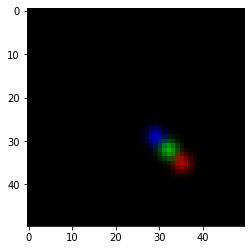

In [3]:
# Create synthetic data
img = np.zeros((3, 2, 1, 50, 50), dtype=np.float32)

# code 1
# round 1
img[0, 0, 0, 35, 35] = 10
# round 2
img[1, 1, 0, 32, 32] = 10
# round 3
img[2, 0, 0, 29, 29] = 10

# blur points
gaussian_filter(img, (0, 0, 0, 1.5, 1.5), output=img)
stack = ImageStack.from_numpy(img)

plt.imshow(np.moveaxis(np.amax(np.squeeze(img),axis=1),0,-1))

We now decode the sequence with `LocalGraphBlobDetector` setting `search_radius` to an approximate value representing the euclidean distance between two spots belonging to different sequencing rounds, and `search_radius_max` to a value representing the maximum euclidean distance between all the spots of the same sequence.

In [4]:
# search_radius=5, search_radius_max=10
lgbd = LocalGraphBlobDetector(search_radius=5, search_radius_max=10, h=0.5)
intensity_table = lgbd.run(stack, n_processes=1)
# One sequence decoded
intensity_table

100%|██████████| 1/1 [00:00<00:00, 181.48it/s]


Generate Graph Model...

Run Graph Model...



<xarray.IntensityTable (features: 1, c: 2, r: 3)>
array([[[0.70737, 0.     , 0.70737],
        [0.     , 0.70737, 0.     ]]])
Coordinates:
    radius   (features) int64 0
    z        (features) int64 0
    y        (features) int64 35
    x        (features) int64 35
  * r        (r) int64 0 1 2
  * c        (c) int64 0 1
    xc       (features) float64 0.0007143
    yc       (features) float64 0.0007143
    zc       (features) float64 0.0
Dimensions without coordinates: features
Attributes:
    starfish:  {"log": [{"method": "LocalGraphBlobDetector", "arguments": {"i...

In [5]:
# search_radius=5, search_radius_max=5
lgbd = LocalGraphBlobDetector(search_radius=5, search_radius_max=5, h=0.5)
intensity_table = lgbd.run(stack, n_processes=1)
# Zero sequence decoded
intensity_table

100%|██████████| 1/1 [00:00<00:00, 288.84it/s]

Generate Graph Model...

Run Graph Model...



<xarray.IntensityTable (features: 0, c: 2, r: 3)>
array([], shape=(0, 2, 3), dtype=float64)
Coordinates:
    radius   (features) int64 
    z        (features) int64 
    y        (features) int64 
    x        (features) int64 
  * r        (r) int64 0 1 2
  * c        (c) int64 0 1
    xc       (features) float64 
    yc       (features) float64 
    zc       (features) float64 
Dimensions without coordinates: features
Attributes:
    starfish:  {"log": [{"method": "LocalGraphBlobDetector", "arguments": {"i...

## Example 2
We now change the distances between the spots such that the 3rd round spot (blue) lay between the other two, and compare the results with other decoding approaches.

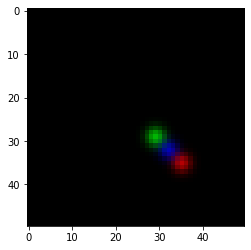

In [6]:
# Create synthetic data
img = np.zeros((3, 2, 1, 50, 50), dtype=np.float32)

# code 1
# round 1
img[0, 0, 0, 35, 35] = 10
# round 2
img[1, 1, 0, 29, 29] = 10
# round 3
img[2, 0, 0, 32, 32] = 10

# blur points
gaussian_filter(img, (0, 0, 0, 1.5, 1.5), output=img)
stack = ImageStack.from_numpy(img)

plt.imshow(np.moveaxis(np.amax(np.squeeze(img),axis=1),0,-1))

In [7]:
# LocalGraphBlobDetector
lgbd = LocalGraphBlobDetector(
    search_radius=5,
    search_radius_max=10,
    detector_method='blob_log',
    min_sigma=(0.4, 1.2, 1.2),
    max_sigma=(0.6, 1.7, 1.7),
    num_sigma=3,
    threshold=0.1,
    overlap=0.5)
intensity_table = lgbd.run(stack, n_processes=1)
intensity_table

100%|██████████| 1/1 [00:00<00:00, 175.95it/s]

Generate Graph Model...

Run Graph Model...



<xarray.IntensityTable (features: 1, c: 2, r: 3)>
array([[[0.70737, 0.     , 0.70737],
        [0.     , 0.70737, 0.     ]]])
Coordinates:
    radius   (features) int64 0
    z        (features) int64 0
    y        (features) int64 35
    x        (features) int64 35
  * r        (r) int64 0 1 2
  * c        (c) int64 0 1
    xc       (features) float64 0.0007143
    yc       (features) float64 0.0007143
    zc       (features) float64 0.0
Dimensions without coordinates: features
Attributes:
    starfish:  {"log": [{"method": "LocalGraphBlobDetector", "arguments": {"i...

`LocalSearchBlobDetector` decode the correct sequence only if `anchor_round` is set to the round of the spot lying in the middle, otherwise will fail to connect all the spots.

In [8]:
# LocalSearchBlobDetector
# Anchor round: 1st round
lgbd = LocalSearchBlobDetector(
    search_radius=5,
    min_sigma=(0.4, 1.2, 1.2),
    max_sigma=(0.6, 1.7, 1.7),
    num_sigma=3,
    threshold=0.1,
    overlap=0.5,
    anchor_round=0)
intensity_table = lgbd.run(stack, n_processes=1)
intensity_table

<xarray.IntensityTable (features: 1, c: 2, r: 3)>
array([[[0.70737,     nan, 0.70737],
        [    nan,     nan,     nan]]])
Coordinates:
    radius   (features) float64 1.333
    z        (features) int64 0
    y        (features) int64 35
    x        (features) int64 35
  * r        (r) int64 0 1 2
  * c        (c) int64 0 1
    xc       (features) float64 0.0007143
    yc       (features) float64 0.0007143
    zc       (features) float64 0.0
Dimensions without coordinates: features
Attributes:
    starfish:  {"log": [{"method": "LocalGraphBlobDetector", "arguments": {"i...

In [9]:
# LocalSearchBlobDetector
# Anchor round: 3rd round
lgbd = LocalSearchBlobDetector(
    search_radius=5,
    min_sigma=(0.4, 1.2, 1.2),
    max_sigma=(0.6, 1.7, 1.7),
    num_sigma=3,
    threshold=0.1,
    overlap=0.5,
    anchor_round=2)
intensity_table = lgbd.run(stack, n_processes=1)
intensity_table

<xarray.IntensityTable (features: 1, c: 2, r: 3)>
array([[[0.70737,     nan, 0.70737],
        [    nan, 0.70737,     nan]]])
Coordinates:
    radius   (features) float64 1.333
    z        (features) int64 0
    y        (features) int64 32
    x        (features) int64 32
  * r        (r) int64 0 1 2
  * c        (c) int64 0 1
    xc       (features) float64 0.0006531
    yc       (features) float64 0.0006531
    zc       (features) float64 0.0
Dimensions without coordinates: features
Attributes:
    starfish:  {"log": [{"method": "LocalGraphBlobDetector", "arguments": {"i...

## Example 3
Let's now add some noise and multiple possible decoding choices. Specifically, the second round has two possible spot candidates one a bit weaker than the other, both equally spaced respect from the spots of the other rounds. `LocalGraphBlobDetector` provides the best possible decoding solution choosing the spot with highest quality for the second round since distance costs are equivalent. The results of `LocalSearchBlobDetector` strongly depends from the initialization of the anchor round (i.e. from where to start the search), providing different solutions for each initialization. 
(Please note that when anchor round is set to the second round, two sequences are decoded, the correct one plus a false positive.)

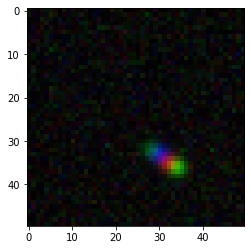

In [25]:
# Create synthetic data
img = np.zeros((3, 2, 1, 50, 50), dtype=np.float32)

# code 1
# round 1
img[0, 0, 0, 35, 32] = 1
# round 2
img[1, 1, 0, 36, 34] = 1
img[1, 0, 0, 32, 28] = 0.5 # Noise
# round 3
img[2, 0, 0, 33, 30] = 1

# blur points
gaussian_filter(img, (0, 0, 0, 1.5, 1.5), output=img)

# add camera noise
np.random.seed(6)
camera_noise = np.random.normal(scale=0.005, size=img.shape).astype(np.float32)
img = img + np.clip(camera_noise,0.001,None)

stack = ImageStack.from_numpy(img)

plt.imshow(np.moveaxis(np.amax(np.squeeze(img*10),axis=1),0,-1))

In [26]:
# LocalGraphBlobDetector
lgbd = LocalGraphBlobDetector(
    search_radius=5,
    search_radius_max=5,
    detector_method='blob_log',
    min_sigma=(0.2, 0.5, 0.5),
    max_sigma=(0.6, 1.7, 1.7),
    num_sigma=3,
    threshold=0.05,
    overlap=0.5)
intensity_table = lgbd.run(stack, n_processes=1)
intensity_table

100%|██████████| 1/1 [00:00<00:00, 238.64it/s]

Generate Graph Model...

Run Graph Model...



<xarray.IntensityTable (features: 1, c: 2, r: 3)>
array([[[0.077548, 0.001   , 0.073696],
        [0.001542, 0.071737, 0.003175]]])
Coordinates:
    radius   (features) int64 0
    z        (features) int64 0
    y        (features) int64 35
    x        (features) int64 32
  * r        (r) int64 0 1 2
  * c        (c) int64 0 1
    xc       (features) float64 0.0006531
    yc       (features) float64 0.0007143
    zc       (features) float64 0.0
Dimensions without coordinates: features
Attributes:
    starfish:  {"log": [{"method": "LocalGraphBlobDetector", "arguments": {"i...

In [29]:
# LocalSearchBlobDetector
# Anchor round: 1st round
lgbd = LocalSearchBlobDetector(
    search_radius=5,
    min_sigma=(0.2, 0.5, 0.5),
    max_sigma=(0.6, 1.7, 1.7),
    num_sigma=3,
    threshold=0.05,
    overlap=0.5,
    anchor_round=0)
intensity_table = lgbd.run(stack, n_processes=1)
intensity_table

<xarray.IntensityTable (features: 2, c: 2, r: 3)>
array([[[     nan, 0.036368, 0.073696],
        [     nan,      nan,      nan]],

       [[0.077548,      nan,      nan],
        [     nan, 0.071737,      nan]]])
Coordinates:
    radius   (features) float64 0.4 0.4
    z        (features) int64 0 0
    y        (features) int64 32 36
    x        (features) int64 28 34
  * r        (r) int64 0 1 2
  * c        (c) int64 0 1
    xc       (features) float64 0.0005714 0.0006939
    yc       (features) float64 0.0006531 0.0007347
    zc       (features) float64 0.0 0.0
Dimensions without coordinates: features
Attributes:
    starfish:  {"log": [{"method": "LocalGraphBlobDetector", "arguments": {"i...

In [ ]:
# LocalSearchBlobDetector
# Anchor round: 2nd round
lgbd = LocalSearchBlobDetector(
    search_radius=5,
    min_sigma=(0.2, 0.5, 0.5),
    max_sigma=(0.6, 1.7, 1.7),
    num_sigma=3,
    threshold=0.05,
    overlap=0.5,
    anchor_round=1)
intensity_table = lgbd.run(stack, n_processes=1)
intensity_table

In [ ]:
# LocalSearchBlobDetector
# Anchor round: 3rd round
lgbd = LocalSearchBlobDetector(
    search_radius=5,
    min_sigma=(0.2, 0.5, 0.5),
    max_sigma=(0.6, 1.7, 1.7),
    num_sigma=3,
    threshold=0.05,
    overlap=0.5,
    anchor_round=2)
intensity_table = lgbd.run(stack, n_processes=1)
intensity_table

## Reproduce In-situ Sequencing results with Starfish Graph-based Decoding

Let's now see the `LocalGraphBlobDetector` applied to In Situ Sequencing (ISS). ISS is an image based transcriptomics technique that can spatially resolve hundreds RNA species and their expression levels in-situ. The protocol and data analysis are described in this [publication](https://www.ncbi.nlm.nih.gov/pubmed/23852452). Here we use the `LocalGraphBlobDetector` to process the raw images from an ISS experiment into a spatially resolved cell by gene expression matrix. And we verify that we can accurately reproduce the results from the authors' original [pipeline](https://cellprofiler.org/previous_examples/#sequencing-rna-molecules-in-situ-combining-cellprofiler-with-imagej-plugins)

Please see [documentation](https://spacetx-starfish.readthedocs.io/en/stable/) for detailed descriptions of all the data structures and methods used here.

In [14]:
matplotlib.rcParams["figure.dpi"] = 150

## Load Data into Starfish from the Cloud

The primary data from one field of view correspond to 16 images from 4 hybridization rounds (r) 4 color channels (c) one z plane (z). Each image is 1044 x 1390 (y, x). These data arise from human breast tissue. O(10) transcripts are barcoded for subsequent spatial resolution.

In [30]:
use_test_data = os.getenv("USE_TEST_DATA") is not None

# An experiment contains a codebook, primary images, and auxiliary images
experiment = data.ISS(use_test_data=use_test_data)
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment._src_doc)

{ 'codebook': 'codebook.json',
  'extras': {},
  'images': { 'dots': 'dots.json',
              'nuclei': 'nuclei.json',
              'primary': 'primary_images.json'},
  'version': '5.0.0'}


In [37]:
fov = experiment.fov()
dots = fov.get_image("dots")
dots_single_plane = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei = fov.get_image("nuclei")
nuclei_single_plane = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)

# note the structure of the 5D tensor containing the raw imaging data
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)
print(imgs)

100%|██████████| 1/1 [00:00<00:00, 32.41it/s]


<starfish.ImageStack (r: 4, c: 4, z: 1, y: 1044, x: 1390)>


## Visualize Codebook

The ISS codebook maps each decoded barcode to a gene.This protocol asserts that genes are encoded with a length 4 quaternary barcode that can be read out from the images. Each round encodes a position in the codeword. The maximum signal in each color channel (columns in the above image) corresponds to a letter in the codeword. The channels, in order, correspond to the letters: 'T', 'G', 'C', 'A'. 

In [38]:
experiment.codebook

<xarray.Codebook (target: 31, c: 4, r: 4)>
array([[[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0]],

       ...,

       [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]],

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'SCUBE2' 'MYBL2' 'ER' ... 'GAPDH' 'HER2' 'ACTB'
  * c        (c) int64 0 1 2 3
  * r        (r) int64 0 1 2 3

## Filter raw data before decoding into spatially resolved gene expression

A White-Tophat filter can be used to enhance spots while minimizing background autoflourescence. The ```masking_radius``` parameter specifies the expected radius, in pixels, of each spot.

In [39]:
from starfish.image import Filter

# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)

filtered_imgs = filt.run(imgs, verbose=True, in_place=False)
filt.run(dots, verbose=True, in_place=True)
filt.run(nuclei, verbose=True, in_place=True)

100%|██████████| 16/16 [00:00<00:00, 55.28it/s]
16it [00:05,  6.55it/s]
1it [00:00, 10.96it/s]
1it [00:00,  9.98it/s]


## Register data
Images may have shifted between imaging rounds. This needs to be corrected for before decoding, since this shift in the images will corrupt the barcodes, thus hindering decoding accuracy. A simple procedure can correct for this shift. For each imaging round, the max projection across color channels should look like the dots stain. Below, we simply shift all images in each round to match the dots stain by learning the shift that maximizes the cross-correlation between the images and the dots stain. 

In [41]:

from starfish.image import ApplyTransform, LearnTransform

learn_translation = LearnTransform.Translation(reference_stack=dots, axes=Axes.ROUND, upsampling=1000)
transforms_list = learn_translation.run(imgs.max_proj(Axes.CH, Axes.ZPLANE))
warp = ApplyTransform.Warp()
registered_imgs = warp.run(filtered_imgs, transforms_list=transforms_list, in_place=False, verbose=True)

100%|██████████| 4/4 [00:00<00:00, 205.87it/s]


## Decode the processed data into spatially resolved gene expression profiles

```LocalGraphBlobDetector``` instance using [Laplacian of Gaussian (LoG)](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=blob_log#skimage.feature.blob_log) blob detection algorithm. Please refer to `scikit-image` documentation for a full parameter list.

In [42]:
from starfish.spots import DetectSpots
import warnings

intensities_lgbd = []
import warnings
lgbd1 = DetectSpots.LocalGraphBlobDetector(
    detector_method='blob_log',
    min_sigma=(0,0.5,0.5),
    max_sigma=(0,3,3),
    num_sigma=10,
    threshold=0.03,
    search_radius=3,
    search_radius_max=5
)

intensities_lgbd.append(lgbd1.run(registered_imgs))

  0%|          | 0/4 [00:00<?, ?it/s]

Generate Graph Model...



  0%|          | 1/4825 [00:00<11:08,  7.22it/s]

Run Graph Model...



100%|██████████| 3982/3982 [00:46<00:00, 85.42it/s] 


```LocalGraphBlobDetector``` instance using [`peak_local_max`](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=peak_local_max#skimage.feature.peak_local_max) local maxima detection algorithm. Please refer to `scikit-image` documentation for a full parameter list.

In [43]:
import warnings
lgbd2 = DetectSpots.LocalGraphBlobDetector(
    detector_method='peak_local_max',
    exclude_border=False,
    threshold_abs=0.03,
    search_radius=3,
    search_radius_max=5
)

intensities_lgbd.append(lgbd2.run(registered_imgs))

  0%|          | 0/4 [00:00<?, ?it/s]

Generate Graph Model...



  0%|          | 0/3658 [00:00<?, ?it/s]

Run Graph Model...



100%|██████████| 3024/3024 [00:17<00:00, 168.26it/s]


```LocalGraphBlobDetector``` instance using [`h_maxima`](https://scikit-image.org/docs/dev/api/skimage.morphology.html?highlight=h_maxima#skimage.morphology.h_maxima) local maxima detection algorithm. Please refer to `scikit-image` documentation for a full parameter list.

In [44]:
import warnings
connectivity=np.array([[[0, 0, 0],[0, 1, 0],[0, 0, 0]],[[0, 1, 0],[1, 1, 1],[0, 1, 0]],[[0, 0, 0],[0, 1, 0],[0, 0, 0]]]) #3D corss  
lgbd3 = DetectSpots.LocalGraphBlobDetector(
    detector_method='h_maxima',
    h=0.015,
    selem=connectivity,
    search_radius=3,
    search_radius_max=5
)

intensities_lgbd.append(lgbd3.run(registered_imgs))

  0%|          | 0/4 [00:00<?, ?it/s]

Generate Graph Model...



  0%|          | 3/2987 [00:00<01:54, 26.13it/s]

Run Graph Model...



100%|██████████| 2775/2775 [00:08<00:00, 312.03it/s]


We now compare the results from the three decoding approaches used previously with `BlobDetector` algorithm. This spot detection finds spots, and record, for each spot, the maximum pixel intensities across rounds and channels.

In [45]:
bd = DetectSpots.BlobDetector(
    min_sigma=0.5,
    max_sigma=3,
    num_sigma=10,
    threshold=0.03,
    measurement_type='max',
)
intensities_bd = bd.run(registered_imgs, blobs_image=dots, blobs_axes=(Axes.ROUND, Axes.ZPLANE))

100%|██████████| 1/1 [00:00<00:00, 175.44it/s]


To decode the resulting intensity tables, we simply match intensities to codewords in the codebook. This can be done by, for each round, selecting the color channel with the maximum intensity. This forms a potential quaternary code which serves as the key into a lookup in the codebook as to which gene this code corresponds to. Decoded genes are assigned to the target field in the decoded intensity table.

In [46]:
decoded_lgbd = []
for i in range(3):
    decoded_lgbd.append(experiment.codebook.decode_per_round_max(intensities_lgbd[i]))

decoded_bd = experiment.codebook.decode_per_round_max(intensities_bd)

We now compare the results of the results from three ```LocalGraphBlobDetector``` instances with respect to `BlobDetector` results, plotting the correlation of decoded read counts. 

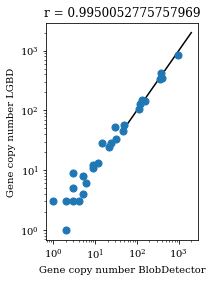

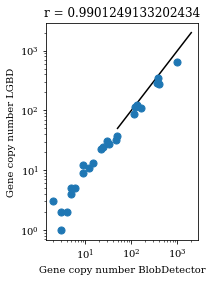

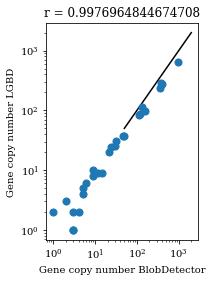

In [49]:
plt.rc('font', family='serif', size=10)
for i in range(3):
    decoded_tmp = decoded_lgbd[i]
    genes_lgbd, counts_lgbd = np.unique(decoded_tmp.loc[decoded_tmp[Features.PASSES_THRESHOLDS]][Features.TARGET], return_counts=True)
    result_counts_lgbd = pd.Series(counts_lgbd, index=genes_lgbd)

    genes_bd, counts_bd = np.unique(decoded_bd.loc[decoded_bd[Features.PASSES_THRESHOLDS]][Features.TARGET], return_counts=True)
    result_counts_bd = pd.Series(counts_bd, index=genes_bd)
    
    tmp = pd.concat([result_counts_lgbd, result_counts_bd], join='inner', axis=1).values

    r = np.corrcoef(tmp[:, 1], tmp[:, 0])[0, 1]
    x = np.linspace(50, 2000)
    
    f = plt.figure()
    ax = plt.subplot(1,2,1)
    ax.scatter(tmp[:, 1], tmp[:, 0], 50, zorder=2)

    ax.plot(x, x, '-k', zorder=1)
    plt.xlabel('Gene copy number BlobDetector')
    plt.ylabel('Gene copy number LGBD')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'r = {r}');

##  Compare to results from paper
This FOV was selected to make sure that we can visualize the tumor/stroma boundary, below this is described by pseudo-coloring HER2 (tumor) and vimentin (VIM, stroma). This distribution matches the one described in the original paper.

100%|██████████| 1/1 [00:00<00:00, 161.47it/s]


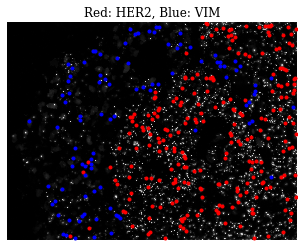

In [51]:
from skimage.color import rgb2gray

decoded_lgbd = decoded_lgbd[2]

GENE1 = 'HER2'
GENE2 = 'VIM'

rgb = np.zeros(registered_imgs.tile_shape + (3,))
nuclei_mp = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_numpy = nuclei_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,0] = nuclei_numpy
dots_mp = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dots_mp_numpy = dots_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,1] = dots_mp_numpy
do = rgb2gray(rgb)
do = do/(do.max())

plt.imshow(do,cmap='gray')
plt.axis('off');

with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    is_gene1 = decoded_lgbd.where(decoded_lgbd[Features.AXIS][Features.TARGET] == GENE1, drop=True)
    is_gene2 = decoded_lgbd.where(decoded_lgbd[Features.AXIS][Features.TARGET] == GENE2, drop=True)

plt.plot(is_gene1.x, is_gene1.y, 'or', markersize=3)
plt.plot(is_gene2.x, is_gene2.y, 'ob', markersize=3)
plt.title(f'Red: {GENE1}, Blue: {GENE2}');